# This notebook has the code for After Merging part of the two datasets

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For better visualization
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

## Load and process two different datasets

In [2]:
# Load datasets
energy_df = pd.read_csv("data/energy_dataset.csv")
weather_df = pd.read_csv("data/weather_features.csv")

## Process Energery Dataset
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True, infer_datetime_format=True)
energy_df = energy_df.set_index('time')
energy_df.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

## Process weather dataset
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df
weather_df = df_convert_dtypes(weather_df, np.int64, np.float64)

# Convert dt_iso to datetime type, rename it and set it as index
weather_df ['time'] = pd.to_datetime(weather_df ['dt_iso'], utc=True, infer_datetime_format=True)
weather_df  = weather_df.drop(['dt_iso'], axis=1)
weather_df = weather_df.set_index('time')
cities = weather_df['city_name'].unique()

# Create df_weather_2 and drop duplicate rows in df_weather
df_weather_2 = weather_df.reset_index().drop_duplicates(subset=['time', 'city_name'], 
                                                        keep='last').set_index('time')
df_weather = weather_df.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='first').set_index('time')

# Drop columns with qualitative weather information
df_weather = df_weather.drop(['weather_main', 'weather_id', 
                              'weather_description', 'weather_icon'], axis=1)

## Merging Two datasets

In [3]:
## Merging two datasets

# Split the df_weather into 5 dataframes (one for each city)
df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

# Merge all dataframes into the final dataframe
df_final = energy_df
for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)
merged_df = df_final.copy()

# Processing day, month, hour
def split_date(df):
    df['Date']= pd.to_datetime(df.index)
    df["Year"]= df.Date.dt.year
    df["Month"] = df.Date.dt.month
    df["Day"] = df.Date.dt.day
    df["Hour"] = df.Date.dt.hour
    df['WeekOfYear'] = df.Date.dt.isocalendar().week
split_date(merged_df)

In [4]:
merged_df.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,rain_1h_Valencia,rain_3h_Valencia,snow_3h_Valencia,clouds_all_Valencia,Date,Year,Month,Day,Hour,WeekOfYear
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,2014-12-31 23:00:00+00:00,2014,12,31,23,1
2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,2015-01-01 00:00:00+00:00,2015,1,1,0,1
2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,2015-01-01 01:00:00+00:00,2015,1,1,1,1
2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,2015-01-01 02:00:00+00:00,2015,1,1,2,1
2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,2015-01-01 03:00:00+00:00,2015,1,1,3,1


## Features Selection

In [5]:
inputs = ['Day','Month','Year','Hour',
          'temp_Barcelona', 'pressure_Barcelona','humidity_Barcelona', 'wind_speed_Barcelona', 
          'temp_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao', 'wind_speed_Bilbao',
          'temp_Madrid','pressure_Madrid','humidity_Madrid', 'wind_speed_Madrid',
          'temp_Seville','pressure_Seville', 'humidity_Seville', 'wind_speed_Seville',
          'temp_Valencia','pressure_Valencia', 'humidity_Valencia', 'wind_speed_Valencia',
        ]

target = 'total load actual'

selected_df = merged_df[inputs+[target]].copy()
selected_df.reset_index(drop=True,inplace=True)
selected_df.head()

,Day,Month,Year,Hour,temp_Barcelona,pressure_Barcelona,humidity_Barcelona,wind_speed_Barcelona,temp_Bilbao,pressure_Bilbao,...,wind_speed_Madrid,temp_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,temp_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,total load actual
0,31,12,2014,23,281.625,1035.0,100.0,7.0,269.657312,1036.0,...,1.0,273.375,1039.0,75.0,1.0,270.475,1001.0,77.0,1.0,25385.0
1,1,1,2015,0,281.625,1035.0,100.0,7.0,269.763500,1035.0,...,1.0,273.375,1039.0,75.0,1.0,270.475,1001.0,77.0,1.0,24382.0
2,1,1,2015,1,281.286,1036.0,100.0,7.0,269.251688,1036.0,...,1.0,274.086,1039.0,71.0,3.0,269.686,1002.0,78.0,0.0,22734.0
3,1,1,2015,2,281.286,1036.0,100.0,7.0,269.203344,1035.0,...,1.0,274.086,1039.0,71.0,3.0,269.686,1002.0,78.0,0.0,21286.0
4,1,1,2015,3,281.286,1036.0,100.0,7.0,269.485500,1035.0,...,1.0,274.086,1039.0,71.0,3.0,269.686,1002.0,78.0,0.0,20264.0


In [6]:
selected_df.describe()

,Day,Month,Year,Hour,temp_Barcelona,pressure_Barcelona,humidity_Barcelona,wind_speed_Barcelona,temp_Bilbao,pressure_Bilbao,...,wind_speed_Madrid,temp_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,temp_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,total load actual
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,3.506400e+04,35064.000000,35064.000000,35064.000000,35064.000000,...,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,15.729637,6.522930,2016.499544,11.500000,289.867178,1.287211e+03,73.830710,2.782740,286.443451,1017.483858,...,2.433807,293.166541,1018.536990,63.780516,2.482717,290.783954,1015.979381,65.093971,2.692477,28698.281385
std,8.800218,3.448752,1.117795,6.922285,6.723623,1.346303e+04,17.720809,1.996081,6.803527,9.820662,...,1.973041,8.082475,6.867486,22.881475,1.868503,7.234569,11.937650,19.678281,2.582959,4575.828854
min,1.000000,1.000000,2014.000000,0.000000,262.240000,0.000000e+00,0.000000,0.000000,266.850000,961.000000,...,0.000000,271.050000,986.000000,7.000000,0.000000,268.830656,969.000000,8.000000,0.000000,18041.000000
25%,8.000000,4.000000,2016.000000,5.750000,284.707375,1.014000e+03,62.000000,1.000000,281.452594,1013.000000,...,1.000000,287.330000,1014.000000,46.000000,1.000000,285.150000,1012.000000,51.000000,1.000000,24807.000000
50%,16.000000,7.000000,2016.000000,11.500000,289.411250,1.017000e+03,76.000000,2.000000,286.170000,1019.000000,...,2.000000,292.440000,1018.000000,67.000000,2.000000,290.190000,1017.000000,67.000000,2.000000,28902.000000
75%,23.000000,10.000000,2017.000000,17.250000,295.150000,1.021000e+03,87.000000,4.000000,291.040000,1024.000000,...,3.000000,298.880000,1023.000000,83.000000,3.000000,296.150000,1021.000000,82.000000,4.000000,32194.250000
max,31.000000,12.000000,2018.000000,23.000000,309.150000,1.008371e+06,100.000000,15.000000,312.470000,1042.000000,...,18.000000,315.600000,1090.000000,100.000000,15.000000,311.150000,1087.000000,100.000000,133.000000,41015.000000


<AxesSubplot:>

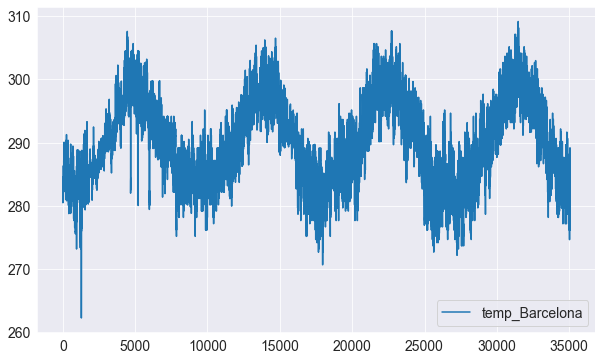

In [7]:
selected_df['temp_Barcelona'].plot(legend=True)

In [8]:
correlations = selected_df.corr(method='pearson')
print(correlations['total load actual'].sort_values(ascending=False).to_string())

total load actual       1.000000
Hour                    0.395586
temp_Valencia           0.220790
temp_Seville            0.204571
temp_Bilbao             0.196535
temp_Madrid             0.185388
temp_Barcelona          0.167338
wind_speed_Bilbao       0.155898
wind_speed_Valencia     0.147982
wind_speed_Seville      0.132973
wind_speed_Barcelona    0.120719
wind_speed_Madrid       0.083669
Year                    0.060122
pressure_Valencia       0.010565
pressure_Madrid         0.006952
pressure_Bilbao        -0.000613
pressure_Barcelona     -0.002199
Day                    -0.005919
pressure_Seville       -0.024875
Month                  -0.040919
humidity_Madrid        -0.201517
humidity_Bilbao        -0.268101
humidity_Seville       -0.283103
humidity_Barcelona     -0.300901
humidity_Valencia      -0.314687


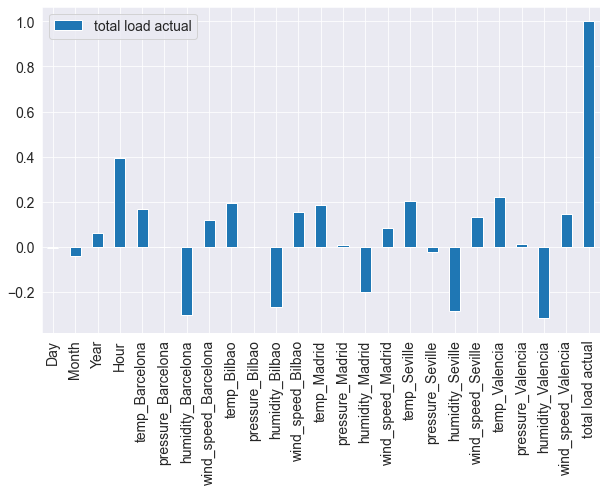

In [9]:
correlations['total load actual'].plot(legend=True,kind='bar',rot=90) #plot usa column
plt.show()

In [10]:
# Saving the dataset to a csv file
selected_df.to_csv('data/merged.csv')

## Splitting datasets into train, validation, and test sets

In [11]:
# Splitting datasets into train, validation and test sets
train_set = selected_df[selected_df["Year"]<2018].copy()
test_set = selected_df[(selected_df["Year"]==2018) & (selected_df["Month"]<=6)].copy()
val_set = selected_df[(selected_df["Year"]==2018) & (selected_df["Month"]>6)].copy()

# Scaling the columns from 0 to 1 limit
scaler = MinMaxScaler().fit(train_set[inputs])
train_set[inputs] = scaler.transform(train_set[inputs])
val_set[inputs] = scaler.transform(val_set[inputs])
test_set[inputs] = scaler.transform(test_set[inputs])

# Setting X and y for train, test, validation
[X_train, y_train] = [train_set[inputs].copy(), train_set[target].copy()]
[X_val, y_val] = [val_set[inputs].copy(), val_set[target].copy()]
[X_test, y_test] = [test_set[inputs].copy(), test_set[target].copy()]

# Checking shape of the datasets
X_train.shape, X_val.shape, X_test.shape

((26305, 24), (4415, 24), (4344, 24))

## Training and Validating the model

In [12]:
# Function for calculating average Deviation
def error_in_parcent(actual, predicted):
    percents = [] 
    actual = actual.to_numpy()
    for i in range(len(actual)):
        p = abs((actual[i]-predicted[i]))/actual[i]
        percents.append(p)
    average =  (sum(percents)/len(percents)) *100
    return float("{:.2f}".format(average))


# Function for checking the model
def checking_error(model):
    train_preds = model.predict(X_train)
    train_deviation = error_in_parcent(y_train, train_preds)
    
    val_preds = model.predict(X_val)
    val_deviation = error_in_parcent(y_val, val_preds)
    
    print(f'Average Deviation on the Traning set: {train_deviation} %')
    print(f'Average Deviation on the Validation set: {val_deviation} %')
    
    # Plot for training
    plt.plot(range(1000,1200),y_train[1000:1200],label = "Actual Value")
    plt.plot(range(1000,1200),train_preds[1000:1200],label = "Predicted Value")
    plt.legend()
    plt.title("Training Results")
    plt.ylim([0, 45000])
    plt.show()
    
    # Plot for validation
    plt.plot(range(1000,1200),y_val[1000:1200],label = "Actual Value")
    plt.plot(range(1000,1200),val_preds[1000:1200],label = "Predicted Value")
    plt.legend()
    plt.title("Validation Results")
    plt.ylim([0, 45000])
    plt.show()

In [13]:
# Training the model
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=11, max_depth=5, subsample=0.8, 
                         colsample_bytree=0.7, seed =1301)
model.fit(X_train, y_train);
print("Training Complete")

Training Complete


Average Deviation on the Traning set: 7.52 %
Average Deviation on the Validation set: 8.29 %


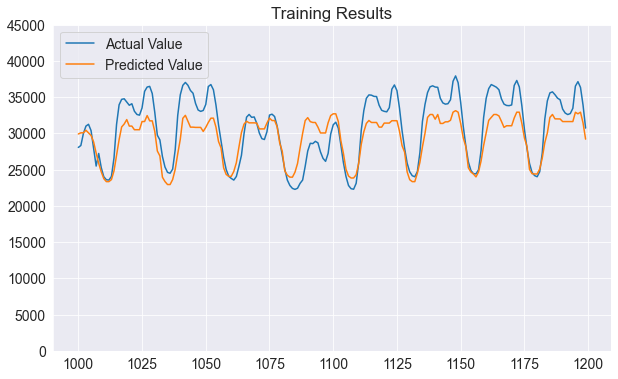

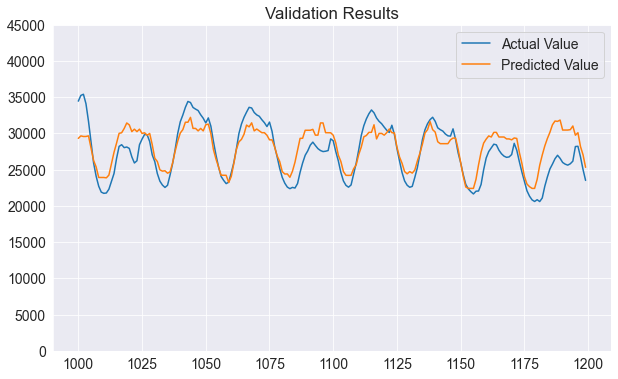

In [14]:
checking_error(model)

## Testing with test set

Average Deviation on the Test set: 8.37 %


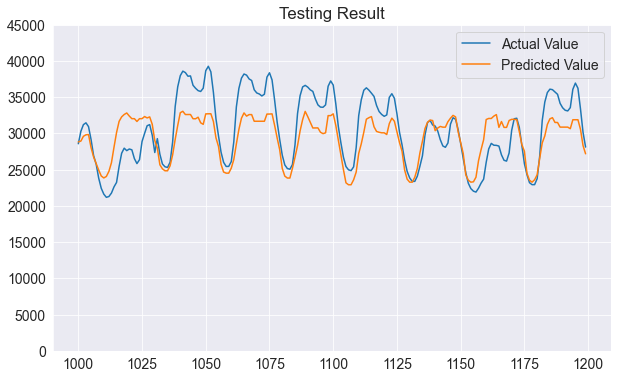

In [15]:
test_preds = model.predict(X_test)
plt.plot(range(1000,1200),y_test[1000:1200],label = "Actual Value")
plt.plot(range(1000,1200),test_preds[1000:1200],label = "Predicted Value")
plt.legend()
plt.title("Testing Result")
plt.ylim([0, 45000])
plt.show
error_in_parcent(y_test, test_preds)
print(f'Average Deviation on the Test set: {error_in_parcent(y_test, test_preds)} %')

## Test with signle Input

In [16]:
def predict_from_input(single_input):
    input_df = pd.DataFrame([single_input])
    input_df[inputs] = scaler.transform(input_df[inputs])
    predicted_result = model.predict(input_df)
    return predicted_result[0]

In [17]:
selected_df.iloc[2111].to_json()

'{"Day":29.0,"Month":3.0,"Year":2015.0,"Hour":22.0,"temp_Barcelona":284.92,"pressure_Barcelona":1023.0,"humidity_Barcelona":100.0,"wind_speed_Barcelona":1.0,"temp_Bilbao":284.542,"pressure_Bilbao":1025.0,"humidity_Bilbao":72.0,"wind_speed_Bilbao":1.0,"temp_Madrid":282.38,"pressure_Madrid":945.0,"humidity_Madrid":71.0,"wind_speed_Madrid":1.0,"temp_Seville":288.97,"pressure_Seville":1033.0,"humidity_Seville":54.0,"wind_speed_Seville":3.0,"temp_Valencia":283.97,"pressure_Valencia":995.0,"humidity_Valencia":75.0,"wind_speed_Valencia":1.0,"total load actual":23928.0}'

In [18]:
single_input = {"Day":29.0,"Month":3.0,"Year":2015.0,"Hour":22.0,
                "temp_Barcelona":284.92,"pressure_Barcelona":1023.0,"humidity_Barcelona":100.0,"wind_speed_Barcelona":1.0,
                "temp_Bilbao":284.542,"pressure_Bilbao":1025.0,"humidity_Bilbao":72.0,"wind_speed_Bilbao":1.0,
                "temp_Madrid":282.38,"pressure_Madrid":945.0,"humidity_Madrid":71.0,"wind_speed_Madrid":1.0,
                "temp_Seville":288.97,"pressure_Seville":1033.0,"humidity_Seville":54.0,"wind_speed_Seville":3.0,
                "temp_Valencia":283.97,"pressure_Valencia":995.0,"humidity_Valencia":75.0,"wind_speed_Valencia":1.0}


# Prediction 
predticted_result = predict_from_input(single_input)
predticted_result 

26331.207

## Saving Model

In [19]:
import joblib

loadForecasting = {
    'model':model,
    "scaler": scaler,
    "inputs": inputs,
    "target": target
}

joblib.dump(loadForecasting, 'loadForecasting.joblib')

['loadForecasting.joblib']